In [214]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
import time
import optuna
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm
from sklearn.metrics import mean_squared_error ,r2_score, mean_absolute_error#, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


from IPython.lib.display import Audio
framerate = 4410
play_time_seconds = 3
t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)

In [2]:
def reduce_mem_usage(df, verbose=True):
    """
    This function helps us to reduce memory usage as we are preprocessing the data
    """
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
data = pd.read_csv('../datasets/nyc-rolling-sales 2.csv')
data = reduce_mem_usage(data)
df = data.copy()

Mem. usage decreased to  9.19 Mb (35.2% reduction)


In [109]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Creates lists for categorical, numerical and complex categorical columns
    """
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    #print(f"Observations: {dataframe.shape[0]}")
    #print(f"Values: {dataframe.shape[1]}")
    #print(f'cat_cols (Categorical Columns): {len(cat_cols)}')
    #print(f'num_cols (Numerical Columns): {len(num_cols)}')
    #print(f'cat_but_car (Complex Categorical Columns): {len(cat_but_car)}')
    #print(f'num_but_cat (Categorical Columns with Numerical Appearance): {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [97]:
def high_corr_list(df, threshold):
    correlation_matrix = df.corr().abs()
    to_drop = set()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i,j]) > threshold:
                col_name = correlation_matrix.columns[i]
                to_drop.add(col_name)
    return to_drop

In [98]:
def replace_outliers_with_thresholds(df, column):
    """
    Replaces outlier values with their thresholds choice by the user.
    """
    
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    # Replace values below lower_bound with lower_bound
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    # Replace values above upper_bound with upper_bound
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return lower_bound, upper_bound

In [172]:
def create_feature(df):
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
    
    df['hour'] = df['SALE DATE'].dt.hour

    df['month'] = df['SALE DATE'].dt.month
    df['day_of_month'] = df['SALE DATE'].dt.day
    df['day_of_year'] = df['SALE DATE'].dt.dayofyear
    df['week_of_year'] = df['SALE DATE'].dt.isocalendar().week
    df['day_of_week'] = df['SALE DATE'].dt.dayofweek
    #df['year'] = df['SALE DATE'].dt.year
    df["is_wknd"] = df['SALE DATE'].dt.weekday // 4
    df['is_month_start'] = df['SALE DATE'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['SALE DATE'].dt.is_month_end.astype(int)
    #df = df.sort_values(by=['SALE DATE'])
    df['YEAR BUILT'] = df['YEAR BUILT'].astype(np.float64)
    del df['SALE DATE']
    
    return df

In [176]:
def processing(df):
    
    # the column 'EASE-MENT' is blank and can be dropped
    df.drop(['EASE-MENT', 'APARTMENT NUMBER', 'ADDRESS', 'Unnamed: 0'], axis=1, inplace=True)
    #del df['APARTMENT NUMBER']
    #del df['ADDRESS']
    #del df['Unnamed: 0']
    
    # Removing rows where 'SALE PRICE' is missing
    df = df[(df['SALE PRICE'] != ' -  ') & (df['SALE PRICE'] != '0')]
    df['SALE PRICE'] = df['SALE PRICE'].astype('int64')
    borough_mapping = {
        '1':'Manhattan',
        '2':'Bronx',
        '3':'Brooklyn',
        '4':'Queens',
        '5':'Staten Island'
    }
    #df['BOROUGH'] = df['BOROUGH'].astype(str).map(borough_mapping)
    
    month_mapping = {1: 'jan',
        2: 'feb',
        3: 'mar',
        4: 'apr',
        5: 'may',
        6: 'jun',
        7: 'jul',
        8: 'aug',
        9: 'sep',
        10: 'oct',
        11: 'nov',
        12: 'dec'
    }
    df['month'] = df['month'].map(month_mapping)
    
    df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].replace(' -  ', 0)
    df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].astype('int64')
    df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].replace(0, np.nan)
    
    df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace(' -  ', 0)
    df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype('int64')
    df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace(0, np.nan)

    # Imputing missing values in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' using the median
    for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)

    map_dict={'-':np.nan,' ':np.nan}
    df.replace(map_dict,inplace = True)

    
    # add variable for consolidated building class category
    conditions = [
        (df['BUILDING CLASS CATEGORY'].str.contains("DWELLINGS")),
        (df['BUILDING CLASS CATEGORY'].str.contains("CONDO")),
        (df['BUILDING CLASS CATEGORY'].str.contains("COOPS")),
        (df['BUILDING CLASS CATEGORY'].str.contains("RENTALS")),
        (df['BUILDING CLASS CATEGORY'].str.contains("OTHER")),
    ]
    values = ['family_home', 'condo', 'coop', 'rental', 'other']
    df['CONSOLIDATED_BUILDING_CLASS_CATEGORY'] = np.select(conditions, values)
    
    # add binary variable for no-elevator (0) vs. elevator (1)
    df['ELEVATOR'] = np.where(df['BUILDING CLASS CATEGORY'].str.contains("ELEVATOR"), 1, 0)
    
    cat_cols, num_cols, cat_but_car = grab_col_names(df)

    num_cols.remove('SALE PRICE')

    ########################################################################################################################
    # plotting sample data
    sns.set()
    cols = ['BOROUGH', 'YEAR BUILT', 'SALE PRICE', 'month']
    sns.pairplot(df[cols],)
    plt.show()
    
    
    
    df['BOROUGH'] = df['BOROUGH'].astype(str).map(borough_mapping)
    
    manhattan_sales = df[df['BOROUGH'] == 'Manhattan']
    manhattan_sales['SALE PRICE'].groupby(manhattan_sales['NEIGHBORHOOD']).mean().plot.bar(figsize=(15, 10))
    plt.title("Properties avg price($M) in Manhattan ")

    avg_price = manhattan_sales[['SALE PRICE']].groupby(manhattan_sales['NEIGHBORHOOD']).mean()
    avg_price = avg_price.sort_values(by='SALE PRICE', ascending=False)
    top_avg_price = avg_price.head(5)
    top_5_neighborhoods = top_avg_price.index.values

    top_5 = df[df['NEIGHBORHOOD'].isin(top_5_neighborhoods)]

    t = top_5[['NEIGHBORHOOD','SALE PRICE', 'month']] 
    t = t.groupby(['NEIGHBORHOOD','month'])[['SALE PRICE']].count()

    t = t.reset_index(level=1)
    t = t.reset_index(level=0)
    
    ax = sns.relplot(x="month",
                         y="SALE PRICE",
                         hue="NEIGHBORHOOD",
                         size="SALE PRICE",
                         sizes=(40, 400),
                         alpha=.5,
                         palette="muted",
                         height=6,
                         data=t)

    ax.set(ylabel="SALE_PRICE_IN_M")
    plt.show()
    

    
    
    year_built_vs_price = df[['YEAR BUILT', 'SALE PRICE']]
    year_built_vs_price = year_built_vs_price[(year_built_vs_price['YEAR BUILT'] > 1800) & (year_built_vs_price['YEAR BUILT'] < 2023)].groupby('YEAR BUILT')[['SALE PRICE']].mean()
    year_built_vs_price = year_built_vs_price.reset_index(level=0)

    ax = sns.histplot(year_built_vs_price['YEAR BUILT'], kde=True)
    ax.set(ylabel="SALE PRICE")
    plt.show()
    
    
    ########################################################################################################################
    
    ohe_cols = cat_cols+cat_but_car
    ohe_cols.remove('hour')
    ohe_cols.remove('day_of_week')
    #ohe_cols.remove('year')
    print(f"ohe cols ------> \n{ohe_cols}")
    df = pd.get_dummies(df, columns = ohe_cols, dummy_na= False)
    
    print(f"------------------REMOVING HIGHLY CORRELATED COLUMNS------------------")
    high_correlated = high_corr_list(df[num_cols], threshold=0.8)
    df.drop(columns = high_correlated, inplace=True)
    
    num_cols = [col for col in num_cols if col not in high_correlated]
    
    print(f"------------------SPLITTING DATA------------------")
    X = df.iloc[:, df.columns != 'SALE PRICE']
    y = df[['SALE PRICE']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    print(f"------------------REMOVING OUTLIERS------------------")
    list_for_outliers = ['RESIDENTIAL UNITS',
                         'COMMERCIAL UNITS',
                         'TOTAL UNITS',
                         'LAND SQUARE FEET',
                         'GROSS SQUARE FEET']
    bounds_info = []
    for column in num_cols:
        lower_bound, upper_bound = replace_outliers_with_thresholds(X_train, column)
        bounds_info.append({
            'Column': column,
            'Lower Bound (5th Percentile)': lower_bound,
            'Upper Bound (95th Percentile)': upper_bound
        })
    
    
    return df, X_train, X_test, y_train, y_test, cat_cols, num_cols, cat_but_car

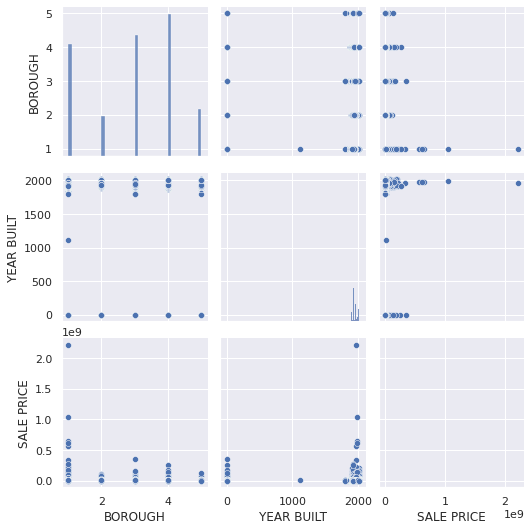

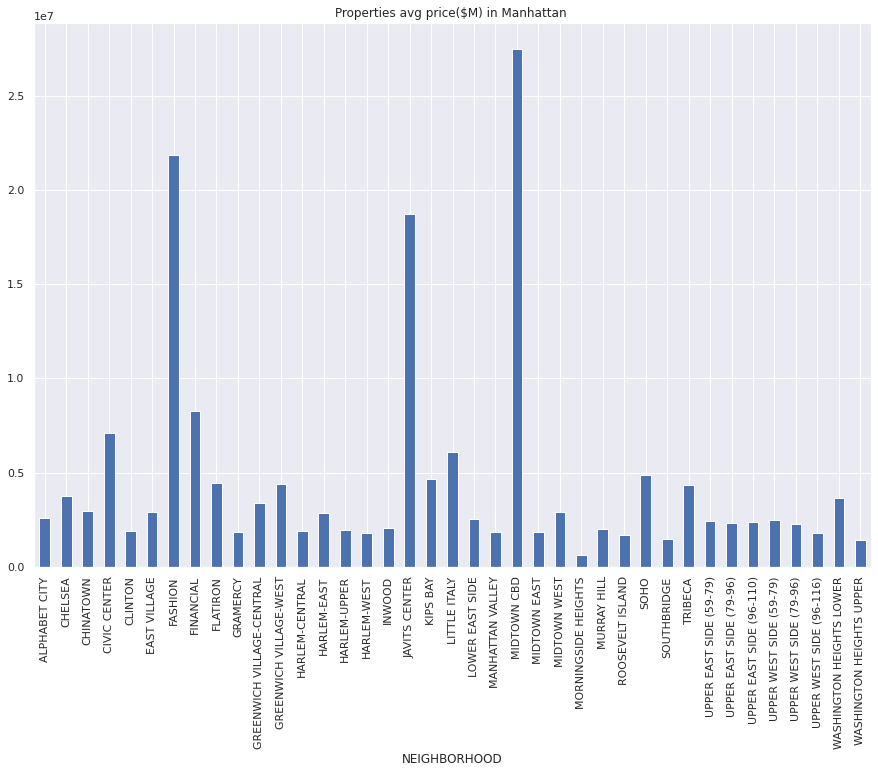

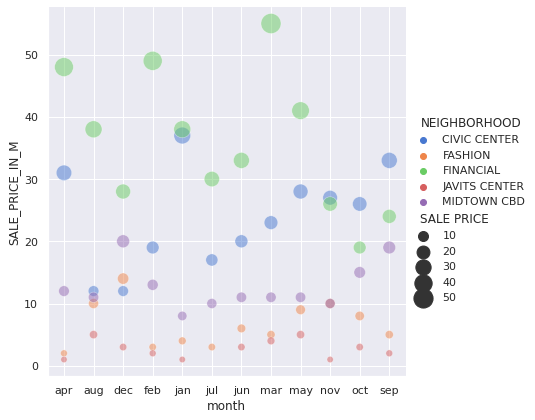

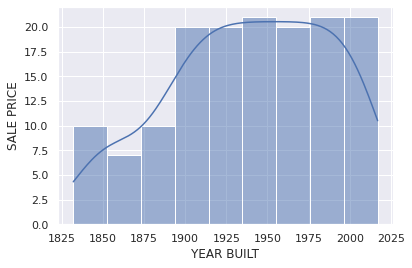

ohe cols ------> 
['TAX CLASS AT PRESENT', 'month', 'CONSOLIDATED_BUILDING_CLASS_CATEGORY', 'BOROUGH', 'TAX CLASS AT TIME OF SALE', 'is_wknd', 'is_month_start', 'is_month_end', 'ELEVATOR', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']
------------------REMOVING HIGHLY CORRELATED COLUMNS------------------
------------------SPLITTING DATA------------------
------------------REMOVING OUTLIERS------------------


,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,hour,day_of_month,day_of_year,day_of_week,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_4,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,CONSOLIDATED_BUILDING_CLASS_CATEGORY_0,CONSOLIDATED_BUILDING_CLASS_CATEGORY_condo,CONSOLIDATED_BUILDING_CLASS_CATEGORY_coop,CONSOLIDATED_BUILDING_CLASS_CATEGORY_family_home,CONSOLIDATED_BUILDING_CLASS_CATEGORY_other,CONSOLIDATED_BUILDING_CLASS_CATEGORY_rental,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,TAX CLASS AT TIME OF SALE_1,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4,is_wknd_0,is_wknd_1,is_month_start_0,is_month_start_1,is_month_end_0,is_month_end_1,ELEVATOR_0,ELEVATOR_1,NEIGHBORHOOD_AIRPORT LA GUARDIA,NEIGHBORHOOD_ALPHABET CITY,NEIGHBORHOOD_ANNADALE,NEIGHBORHOOD_ARDEN HEIGHTS,NEIGHBORHOOD_ARROCHAR,NEIGHBORHOOD_ARROCHAR-SHORE ACRES,NEIGHBORHOOD_ARVERNE,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_BATH BEACH,NEIGHBORHOOD_BATHGATE,NEIGHBORHOOD_BAY RIDGE,NEIGHBORHOOD_BAYCHESTER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_BEDFORD PARK/NORWOOD,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BEECHHURST,NEIGHBORHOOD_BELLE HARBOR,NEIGHBORHOOD_BELLEROSE,NEIGHBORHOOD_BELMONT,NEIGHBORHOOD_BENSONHURST,NEIGHBORHOOD_BERGEN BEACH,NEIGHBORHOOD_BLOOMFIELD,NEIGHBORHOOD_BOERUM HILL,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_BRIARWOOD,NEIGHBORHOOD_BRIGHTON BEACH,NEIGHBORHOOD_BROAD CHANNEL,NEIGHBORHOOD_BRONX PARK,NEIGHBORHOOD_BRONXDALE,NEIGHBORHOOD_BROOKLYN HEIGHTS,NEIGHBORHOOD_BROWNSVILLE,NEIGHBORHOOD_BULLS HEAD,NEIGHBORHOOD_BUSH TERMINAL,NEIGHBORHOOD_BUSHWICK,NEIGHBORHOOD_CAMBRIA HEIGHTS,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_CARROLL GARDENS,NEIGHBORHOOD_CASTLE HILL/UNIONPORT,NEIGHBORHOOD_CASTLETON CORNERS,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_CHINATOWN,NEIGHBORHOOD_CITY ISLAND,NEIGHBORHOOD_CITY ISLAND-PELHAM STRIP,NEIGHBORHOOD_CIVIC CENTER,NEIGHBORHOOD_CLINTON,NEIGHBORHOOD_CLINTON HILL,NEIGHBORHOOD_CLOVE LAKES,NEIGHBORHOOD_CO-OP CITY,NEIGHBORHOOD_COBBLE HILL,NEIGHBORHOOD_COBBLE HILL-WEST,NEIGHBORHOOD_COLLEGE POINT,NEIGHBORHOOD_CONCORD,NEIGHBORHOOD_CONCORD-FOX HILLS,NEIGHBORHOOD_CONEY ISLAND,NEIGHBORHOOD_CORONA,NEIGHBORHOOD_COUNTRY CLUB,NEIGHBORHOOD_CROTONA PARK,NEIGHBORHOOD_CROWN HEIGHTS,NEIGHBORHOOD_CYPRESS HILLS,NEIGHBORHOOD_DONGAN HILLS,NEIGHBORHOOD_DONGAN HILLS-COLONY,NEIGHBORHOOD_DONGAN HILLS-OLD TOWN,NEIGHBORHOOD_DOUGLASTON,NEIGHBORHOOD_DOWNTOWN-FULTON FERRY,NEIGHBORHOOD_DOWNTOWN-FULTON MALL,NEIGHBORHOOD_DOWNTOWN-METROTECH,NEIGHBORHOOD_DYKER HEIGHTS,NEIGHBORHOOD_EAST ELMHURST,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_EAST RIVER,NEIGHBORHOOD_EAST TREMONT,NEIGHBORHOOD_EAST VILLAGE,NEIGHBORHOOD_ELMHURST,NEIGHBORHOOD_ELTINGVILLE,NEIGHBORHOOD_EMERSON HILL,NEIGHBORHOOD_FAR ROCKAWAY,NEIGHBORHOOD_FASHION,NEIGHBORHOOD_FIELDSTON,NEIGHBORHOOD_FINANCIAL,NEIGHBORHOOD_FLATBUSH-CENTRAL,NEIGHBORHOOD_FLATBUSH-EAST,NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN,NEIGHBORHOOD_FLATBUSH-NORTH,NEIGHBORHOOD_FLATIRON,NEIGHBORHOOD_FLATLANDS,NEIGHBORHOOD_FLORAL PARK,NEIGHBORHOOD_FLUSHING MEADOW PARK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_FORDHAM,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_FORT GREENE,NEIGHBORHOOD_FRESH KILLS,NEIGHBORHOOD_FRESH MEADOWS,NEIGHBORHOOD_GERRITSEN BEACH,NEIGHBORHOOD_GLEN OAKS,NEIGHBORHOOD_GLENDALE,NEIGHBORHOOD_GOWANUS,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_GRANT CITY,NEIGHBORHOOD_GRASMERE,NEIGHBORHOOD_GRAVESEND,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_GREAT KILLS-BAY TERRACE,NEIGHBORHOOD_GREENPOINT,NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL,NEIGHBORHOOD_GREENWICH VILLAGE-WEST,NEIGHBORHOOD_GRYMES HILL,NEIGHBORHOOD_HAMMELS,NEIGHBORHOOD_HARLEM-CENTRAL,NEIGHBORHOOD_HARLEM-EAST,NEIGHBORHOOD_HARLEM-UPPER,NEIGHBORHOOD_HARLEM-WEST,NEIGHBORHOO

In [177]:
df = data.copy()
df = create_feature(df)
df, X_train, X_test, y_train, y_test, cat_cols, num_cols, cat_but_car = processing(df)
df

In [108]:
num_cols

['BLOCK',
 'LOT',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'day_of_month',
 'day_of_year',
 'week_of_year']

In [179]:
# Popular Regression Algorithms

lm = LinearRegression()
lgbm = lightgbm.LGBMRegressor(random_state = 42)
mlp = MLPRegressor(random_state = 42)
ridge = Ridge(random_state = 42)
lasso = Lasso(random_state = 42)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state = 42)
xgbt = xgb.XGBRegressor(random_state = 42)
dtree = DecisionTreeRegressor(random_state = 42)

In [180]:
algo = [xgbt,lgbm,lm,ridge,lasso,knn,rf,dtree,mlp]
result = []

for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sn")
        
result_raw_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
result_raw_model

XGBRegressor ✓     278.5106583890001 sn
LGBMRegressor ✓     27.805579809999927 sn
LinearRegression ✓     22.755613984999854 sn
Ridge ✓     16.695934576000127 sn
Lasso ✓     182.20414594 sn
KNeighborsRegressor ✓     1457.4755450760001 sn
RandomForestRegressor ✓     253.07136608700011 sn
DecisionTreeRegressor ✓     4.635970411000017 sn
MLPRegressor ✓     12533.722434671 sn


,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
XGBRegressor_baseline,0.954031,4.922673e-01,1.950216e+06,1.476072e+07,6.071126e+05,9.196447e+05
DecisionTreeRegressor_baseline,0.998792,4.830395e-01,3.161959e+05,1.489425e+07,9.342910e+03,9.636489e+05
RandomForestRegressor_baseline,0.905420,3.099393e-01,2.797352e+06,1.720813e+07,2.996909e+05,8.177488e+05
LGBMRegressor_baseline,0.702871,8.299534e-02,4.958163e+06,1.983699e+07,8.433110e+05,1.055758e+06
KNeighborsRegressor_baseline,0.531398,2.170964e-02,6.226589e+06,2.048915e+07,7.785006e+05,1.001084e+06
Lasso_baseline,0.391532,-3.404940e-01,7.095242e+06,2.398404e+07,1.211282e+06,2.218879e+06
Ridge_baseline,0.388522,-4.307001e-01,7.112768e+06,2.477789e+07,1.231284e+06,2.297336e+06
MLPRegressor_baseline,0.039526,-1.659579e+00,8.914380e+06,3.378286e+07,1.701541e+06,3.073506e+06
LinearRegression_baseline,0.391568,-7.921700e+14,7.095031e+06,5.830411e+14,1.210623e+06,4.033744e+13


In [228]:
def objective(trial):
    params = {
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4)
    }
    
    

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
XGBRegressor_baseline,0.954031,4.922673e-01,1.950216e+06,1.476072e+07,6.071126e+05,9.196447e+05
DecisionTreeRegressor_baseline,0.998792,4.830395e-01,3.161959e+05,1.489425e+07,9.342910e+03,9.636489e+05
RandomForestRegressor_baseline,0.905420,3.099393e-01,2.797352e+06,1.720813e+07,2.996909e+05,8.177488e+05
LGBMRegressor_baseline,0.702871,8.299534e-02,4.958163e+06,1.983699e+07,8.433110e+05,1.055758e+06
KNeighborsRegressor_baseline,0.531398,2.170964e-02,6.226589e+06,2.048915e+07,7.785006e+05,1.001084e+06
Lasso_baseline,0.391532,-3.404940e-01,7.095242e+06,2.398404e+07,1.211282e+06,2.218879e+06
Ridge_baseline,0.388522,-4.307001e-01,7.112768e+06,2.477789e+07,1.231284e+06,2.297336e+06
MLPRegressor_baseline,0.039526,-1.659579e+00,8.914380e+06,3.378286e+07,1.701541e+06,3.073506e+06
LinearRegression_baseline,0.391568,-7.921700e+14,7.095031e+06,5.830411e+14,1.210623e+06,4.033744e+13


**Best performing models appears to be XGBRegressor and DecisionTreeRegressor. Lets finetune both models and compare one more time.**

In [202]:
"""
params = { 'max_depth': [3, 5, 6, 10, 15, 20, 50, 100],
           'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 200, 500, 1000]}

clf = RandomizedSearchCV(estimator = xgbt,
                   param_distributions = params,
                   scoring = 'neg_mean_squared_error',
                   verbose = 0,
                   n_jobs = -1)

clf.fit(X_train, y_train)
clf.best_estimator_
"""

def objective(trial):

    param_grid = {
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
    } 
    
    reg = xgb.XGBRegressor(
        # These parameters should help with trial speed.
        random_state=42,
        objective='reg:tweedie',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs=4,
        **param_grid
    )
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)], eval_metric='rmse',
            verbose=False)

    # Returns the best RMSE for the trial.
    # Readers may want to try returning a cross validation score here.
    return my_rmse(y_test, reg.predict(X_test))

In [205]:
# Create a study and specify the direction to maximize the accuracy
study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
study.optimize(objective, timeout=10)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('\tValue: {}'.format(trial.value))
print('\tParams: ')
for key, value in trial.params.items():
    print('\t\t{}: {}'.format(key, value))

display(Audio(audio_data, rate=framerate, autoplay=True))

[I 2024-08-05 18:23:05,776] A new study created in memory with name: XGBRegressor
[W 2024-08-05 18:23:06,625] Trial 0 failed because of the following error: XGBoostError('[18:23:06] ../src/gbm/gbtree.cc:540: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.\nStack trace:\n  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f52e0a2b459]\n  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e5471) [0x7f52e0a2c471]\n  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f52e0a2c95a]\n  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f52e0a6ca3d]\n  [bt] (4) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f52e0906098]\n  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f53de898a4a]\n  [bt] (6) /opt/conda/lib/python3.7/lib-dynload/

[18:23:06] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [18:23:06] ../src/gbm/gbtree.cc:540: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f52e0a2b459]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e5471) [0x7f52e0a2c471]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f52e0a2c95a]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f52e0a6ca3d]
  [bt] (4) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f52e0906098]
  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f53de898a4a]
  [bt] (6) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f53de897fea]
  [bt] (7) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2f4) [0x7f53de8ae784]
  [bt] (8) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x10ff8) [0x7f53de8aeff8]



In [224]:
def objective(trial, X_train, y_train, group, score, params=dict()):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    #class_weight = (y.shape[0] - np.sum(y_train)) / np.sum(y)
    
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform('min_child_weight',
                                                              1e-10, 1e10)
    
    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0, 1)
    
    if group == '3':
        params['learning_rate'] = trial.suggest_uniform('learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100, 1000)

    pruning_callback = XGBoostPruningCallback(trial, "test-" + score.__name__)
    cv_scores = xgbt.cv(params, dtrain, nfold=5,
                       stratified=True,
                       feval=score,
                       early_stopping_rounds=10,
                       callbacks=[pruning_callback],
                       seed=0)

    return cv_scores['test-' + score.__name__ + '-mean'].values[-1]


def execute_optimization(study_name, group, score, trials,
                         params=dict(), direction='maximize'):
    logging.set_verbosity(logging.ERROR)
    
    ## We use pruner to skip trials that are NOT fruitful
    pruner = MedianPruner(n_warmup_steps=5)
    
    study = create_study(direction=direction,
                         study_name=study_name,
                         storage='sqlite:///optuna.db',
                         load_if_exists=True,
                         pruner=pruner)

    study.optimize(lambda trial: objective(trial, X_train, y_train,
                                           group, score, params),
                   n_trials=trials,
                   n_jobs=-1)
    
    
    print("STUDY NAME: ", study_name)
    print('------------------------------------------------')
    print("EVALUATION METRIC: ", score.__name__)
    print('------------------------------------------------')
    print("BEST CV SCORE", study.best_value)
    print('------------------------------------------------')
    print(f"OPTIMAL GROUP - {group} PARAMS: ", study.best_params)
    print('------------------------------------------------')
    print("BEST TRIAL", study.best_trial)
    print('------------------------------------------------')
    
    
    return study.best_params

In [225]:
score_func = mean_squared_error
def score_function(y_pred, dtrain):
    y_pred = (y_pred > 0.5).astype(int)
    y_true = (dtrain.get_label() > 0.5).astype(int)
    return score_func.__name__, score_func(y_true, y_pred)

score_function.__name__ = score_func.__name__

In [226]:
def stepwise_optimization(trials=10):
    final_params = dict()
    for g in ['1', '2', '3']:
        print(f"=========================== Optimizing Group - {g} ============================")
        update_params = execute_optimization('xgboost', g, score_function, trials,
                                             params=final_params, direction='maximize')
        final_params.update(update_params)
        print(f"PARAMS after optimizing GROUP - {g}: ", final_params)
        print()
        print()

    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    
    return final_params

In [227]:
params = stepwise_optimization()

=========================== Optimizing Group - 1 ============================
STUDY NAME:  xgboost
------------------------------------------------
EVALUATION METRIC:  mean_squared_error
------------------------------------------------


ValueError: Record does not exist.

In [114]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)